In [1]:
print("ok to go")

ok to go


In [2]:
import os ,sys
print(os.getcwd())

e:\AI_workshop\LLMops_Projects\Automated-research-report-generation\research_and_analyst\notebook


In [3]:
project_root=os.path.abspath(os.path.join(os.getcwd(),".."))

In [4]:
project_root

'e:\\AI_workshop\\LLMops_Projects\\Automated-research-report-generation\\research_and_analyst'

In [5]:
sys.path.append(project_root)

In [6]:
import os
import sys
project_root=os.path.abspath(os.path.join(os.getcwd(),"../.."))
sys.path.append(project_root)

print("project root added to path :",project_root)

project root added to path : e:\AI_workshop\LLMops_Projects\Automated-research-report-generation


In [7]:
import os
import sys
sys.path.append(os.path.abspath('..'))

In [8]:
from research_and_analyst.utils.model_loader import ModelLoader

In [9]:
model_loader= ModelLoader()

{"timestamp": "2025-11-01T15:32:29.918331Z", "level": "info", "event": "OPENAI_API_KEY loaded from environment"}
{"timestamp": "2025-11-01T15:32:29.919339Z", "level": "info", "event": "GOOGLE_API_KEY loaded from environment"}
{"timestamp": "2025-11-01T15:32:29.920872Z", "level": "info", "event": "GROQ_API_KEY loaded from environment"}
{"timestamp": "2025-11-01T15:32:29.920872Z", "level": "warning", "event": "ASTRA_DB_API_ENDPOINT is missing from environment"}
{"timestamp": "2025-11-01T15:32:29.920872Z", "level": "warning", "event": "ASTRA_DB_APPLICATION_TOKEN is missing from environment"}
{"timestamp": "2025-11-01T15:32:29.920872Z", "level": "warning", "event": "ASTRA_DB_KEYSPACE is missing from environment"}
{"config_keys": ["astra_db", "embedding_model", "retriever", "llm"], "timestamp": "2025-11-01T15:32:29.940195Z", "level": "info", "event": "YAML config loaded"}


In [10]:
llm=model_loader.load_llm()

{"provider": "google", "model": "gemini-2.0-flash", "timestamp": "2025-11-01T15:32:33.095656Z", "level": "info", "event": "Loading LLM"}


In [11]:
llm.invoke("hi").content

'Hi there! How can I help you today?'

In [12]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel,Field

In [13]:
from langgraph.graph import StateGraph,START,END
from langchain_core.messages import AIMessage,HumanMessage,SystemMessage
from langgraph.checkpoint.memory import MemorySaver

## health

Analyst( name="Dr. Neha Patel", 
role="Medical Data Scientist", 
affiliation="Stanford Medicine", 
description="Focuses on predictive models for patient outcomes." 
),

Analyst( name="Dr. Arun Verma", 
role="Ethics Researcher", 
affiliation="WHO", 
description="Explores ethical implications of AI in diagnostics." ), 

Analyst( name="Ms. Priya Sharma", 
role="Policy Analyst", 
affiliation="Ministry of Health", 
description="Investigates AI policy and compliance frameworks." )

In [14]:
class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst.")
    role: str = Field(description="Role of the analyst in the context of the topic.")
    affiliation: str = Field(description="Primary affiliation of the analyst.")
    description: str = Field(description="Description of the analyst focus, concerns, and motives.")
    
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"
    


In [15]:
Analyst(
    name="sunny savita",
    role="genai eng",
    affiliation="AI Research LAB",
    description="I am genai developer as well as mentor"
    )

Analyst(name='sunny savita', role='genai eng', affiliation='AI Research LAB', description='I am genai developer as well as mentor')

In [16]:
analyst = Analyst(
    name="sunny savita",
    role="genai eng",
    affiliation="AI Research LAB",
    description="I am genai developer as well as mentor"
    )

In [17]:
analyst.name

'sunny savita'

In [18]:
analyst.role

'genai eng'

In [19]:
analyst.affiliation

'AI Research LAB'

In [20]:
print(analyst.persona)

Name: sunny savita
Role: genai eng
Affiliation: AI Research LAB
Description: I am genai developer as well as mentor



In [21]:
class Perspectives(BaseModel):
       analysts: List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations.")

In [22]:
class GenerateAnalystsState(TypedDict):
    topic: str #research topic
    max_analysts: int # number of analyst
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    

In [23]:
GenerateAnalystsState(
    topic = "finance",
    max_analysts= 5,
    human_analyst_feedback= "give the real info",  
)

{'topic': 'finance',
 'max_analysts': 5,
 'human_analyst_feedback': 'give the real info'}

In [24]:
Analyst(
        name="Dr. Neha Patel",
        role="Medical Data Scientist",
        affiliation="Stanford Medicine",
        description="Focuses on predictive models for patient outcomes."
    ),

(Analyst(name='Dr. Neha Patel', role='Medical Data Scientist', affiliation='Stanford Medicine', description='Focuses on predictive models for patient outcomes.'),)

In [25]:
analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

In [26]:
print([analyst_instructions.format(
        topic="education",
        max_analysts=4,
        human_analyst_feedback="please exaplain only on AI"
        
        )] + ["Generate the set of analysts."])

['You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:\n\n1. First, review the research topic:\neducation\n\n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: \n\nplease exaplain only on AI\n\n3. Determine the most interesting themes based upon documents and / or feedback above.\n\n4. Pick the top 4 themes.\n\n5. Assign one analyst to each theme.', 'Generate the set of analysts.']


In [27]:
def create_analyst(state:GenerateAnalystsState):
    """
    it is creating my analyst
    
    """
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback","")
    
    structured_llm = llm.with_structured_output(Perspectives)
    
    system_messages = analyst_instructions.format(
        topic=topic,
        max_analysts=max_analysts,
        human_analyst_feedback=human_analyst_feedback
        
        )
    analysts = structured_llm.invoke([SystemMessage(content=system_messages)]+ [HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}
    

In [28]:
create_analyst(
    {'topic': 'health',
    'max_analysts': 2,
    'human_analyst_feedback': 'give the real info'}
    )

{'analysts': [Analyst(name='Dr. Emily Carter', role='Public Health Researcher', affiliation='National Institutes of Health', description='Focuses on preventative healthcare and the impact of public health policies on community well-being. Concerned with health equity and access to care for underserved populations.'),
  Analyst(name='Dr. David Chen', role='Healthcare Economist', affiliation='Harvard Medical School', description='Analyzes healthcare costs, insurance models, and the economic impact of medical innovations. Motivated by finding sustainable and efficient solutions to healthcare financing challenges.')]}

In [29]:
def human_feedback(state):
    """ No-op node that should be interrupted on """
    pass

In [31]:
def should_continue(state):
    feedback = (state.get("human_analyst_feedback") or "").strip().lower()
    if feedback and feedback not in ["", "none", "skip", "done", "continue"]:
        return "create_analyst"
    return END

In [ ]:
# def should_continue(state):
#     """ Return the next node to execute """
#     human_analyst_feedback = state.get("human_analyst_feedback",None)
#     if human_analyst_feedback:
#         return "create_analyst"

### First Workflow

In [32]:
from IPython.display import Image,display

In [33]:
builder = StateGraph(GenerateAnalystsState)

In [34]:
builder.add_node("create_analyst",create_analyst)
builder.add_node("human_feedback",human_feedback)


In [35]:
builder.add_edge(START,"create_analyst")
builder.add_edge("create_analyst", "human_feedback")
builder.add_conditional_edges("human_feedback",
                        should_continue,
                        ["create_analyst",
                        END])

In [36]:
memory= MemorySaver()

In [37]:
graph = builder.compile(interrupt_before= ["human_feedback"],checkpointer= memory)


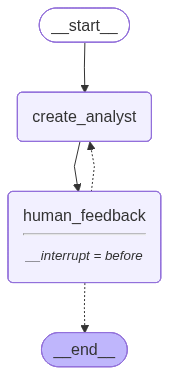

In [38]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [39]:
topic = "the benefits of adopting Langgraph as an agent framework"

In [40]:
max_analysts = 4

In [41]:
thread =  {"configurable":{"thread_id":1}}

In [42]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  
            

Name: Alice Chen
Affiliation: TechForward Innovations
Role: Lead AI Architect
Description: Focuses on the architectural benefits of Langgraph, particularly its modularity and scalability for complex agent systems. She is motivated by building robust and maintainable AI solutions.
--------------------------------------------------
Name: Bob Johnson
Affiliation: Sentinel AI Ethics Group
Role: AI Risk Management Officer
Description: Concerned with the safety and ethical implications of Langgraph, especially regarding its use in autonomous agents. He seeks to ensure responsible development and deployment, focusing on mitigating potential risks.
--------------------------------------------------
Name: Charlie Davis
Affiliation: QuantumLeap AI Research
Role: AI Research Scientist
Description: Interested in Langgraph's potential for advancing AI research, particularly in areas like multi-agent collaboration and complex reasoning. He is driven by exploring novel applications and pushing the bo

In [43]:
state = graph.get_state(thread)

In [44]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'analysts': [Analyst(name='Alice Chen', role='Lead AI Architect', affiliation='TechForward Innovations', description='Focuses on the architectural benefits of Langgraph, particularly its modularity and scalability for complex agent systems. She is motivated by building robust and maintainable AI solutions.'), Analyst(name='Bob Johnson', role='AI Risk Management Officer', affiliation='Sentinel AI Ethics Group', description='Concerned with the safety and ethical implications of Langgraph, especially regarding its use in autonomous agents. He seeks to ensure responsible development and deployment, focusing on mitigating potential risks.'), Analyst(name='Charlie Davis', role='AI Research Scientist', affiliation='QuantumLeap AI Research', description="Interested in Langgraph's potential for advancing AI research, particularly in areas like multi-agent collaboration and complex reaso

In [45]:
state.values

{'topic': 'the benefits of adopting Langgraph as an agent framework',
 'max_analysts': 4,
 'analysts': [Analyst(name='Alice Chen', role='Lead AI Architect', affiliation='TechForward Innovations', description='Focuses on the architectural benefits of Langgraph, particularly its modularity and scalability for complex agent systems. She is motivated by building robust and maintainable AI solutions.'),
  Analyst(name='Bob Johnson', role='AI Risk Management Officer', affiliation='Sentinel AI Ethics Group', description='Concerned with the safety and ethical implications of Langgraph, especially regarding its use in autonomous agents. He seeks to ensure responsible development and deployment, focusing on mitigating potential risks.'),
  Analyst(name='Charlie Davis', role='AI Research Scientist', affiliation='QuantumLeap AI Research', description="Interested in Langgraph's potential for advancing AI research, particularly in areas like multi-agent collaboration and complex reasoning. He is dri

In [46]:
state.next


('human_feedback',)

In [47]:
# memory.storage
memory.storage.items()

dict_items([('1', defaultdict(<class 'dict'>, {'': {'1f0b73a4-8897-6ee1-bfff-1f1d59bb04a8': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2025-11-01T15:49:00.144201+00:00\xa2id\xd9$1f0b73a4-8897-6ee1-bfff-1f1d59bb04a8\xb0channel_versions\x81\xa9__start__\xd9300000000000000000000000000000001.0.9769750189440749\xadversions_seen\x81\xa9__input__\x80\xb0updated_channels\x91\xa9__start__'), ('msgpack', b'\x83\xa6source\xa5input\xa4step\xff\xa7parents\x80'), None), '1f0b73a4-88a2-6797-8000-28183c0da20e': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2025-11-01T15:49:00.148520+00:00\xa2id\xd9$1f0b73a4-88a2-6797-8000-28183c0da20e\xb0channel_versions\x84\xa9__start__\xd9300000000000000000000000000000002.0.8506992444797384\xa5topic\xd9300000000000000000000000000000002.0.8506992444797384\xacmax_analysts\xd9300000000000000000000000000000002.0.8506992444797384\xb8branch:to:create_analyst\xd9300000000000000000000000000000002.0.8506992444797384\xadversions_seen\x82\xa9__input__\x80\xa9__start__\x81\xa9__start__\xd

In [51]:
# import msgpack

# for thread_id, ns_dict in memory.storage.items():
#     print(f"\n Thread ID: {thread_id}")
    
#     # ns_dict = defaultdict(dict, {'': {...}})
#     for ns, ckpts in ns_dict.items():
#         print(f"  Namespace: '{ns}'")
        
#         # ckpts = dict of {checkpoint_id: (packed_values, packed_metadata, parent_id)}
#         for ckpt_id, (packed_values, packed_metadata, parent_id) in ckpts.items():
#             print(f"    Checkpoint ID: {ckpt_id}")
            
#             # Decode msgpack binary
#             values = msgpack.unpackb(packed_values[1], raw=False)
#             meta = msgpack.unpackb(packed_metadata[1], raw=False)
            
#             print(f"    Values keys: {list(values.keys())}")
#             print(f"    Parent ID: {parent_id}")
#             print(f"    Metadata: {meta}")
#             print("-" * 80)

In [48]:
state.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b73a4-b3ce-6ec4-8001-4b82436e94aa'}}

In [49]:
graph.update_state(thread,
                   {"human_analyst_feedback":"add something from the startup perspective and focus on the latest enterprise application"},as_node="human_feedback"
                   )

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b73ae-f690-6b5c-8002-a0c69759c9e6'}}

In [50]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Alice Chen
Affiliation: TechForward Innovations
Role: Lead AI Architect
Description: Focuses on the architectural benefits of Langgraph, particularly its modularity and scalability for complex agent systems. She is motivated by building robust and maintainable AI solutions.
--------------------------------------------------
Name: Bob Johnson
Affiliation: Sentinel AI Ethics Group
Role: AI Risk Management Officer
Description: Concerned with the safety and ethical implications of Langgraph, especially regarding its use in autonomous agents. He seeks to ensure responsible development and deployment, focusing on mitigating potential risks.
--------------------------------------------------
Name: Charlie Davis
Affiliation: QuantumLeap AI Research
Role: AI Research Scientist
Description: Interested in Langgraph's potential for advancing AI research, particularly in areas like multi-agent collaboration and complex reasoning. He is driven by exploring novel applications and pushing the bo

In [51]:
state = graph.get_state(thread)

In [52]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application', 'analysts': [Analyst(name='Ava Chen', role='Startup CTO', affiliation='InnovateAI', description="Focuses on Langgraph's rapid prototyping capabilities and its impact on quickly iterating on AI product features. Concerned with minimizing development costs and maximizing speed to market. Motivated by gaining a competitive edge in the fast-paced startup environment."), Analyst(name='Raj Patel', role='Enterprise AI Architect', affiliation='GlobalTech Solutions', description="Interested in Langgraph's scalability and robustness for enterprise-level AI applications. Concerned with ensuring seamless integration with existing infrastructure and maintaining high levels of security and compliance. Motivated by delivering reliable and impactful AI solutions across the org

In [53]:
state.next

('human_feedback',)

In [54]:
state.values

{'topic': 'the benefits of adopting Langgraph as an agent framework',
 'max_analysts': 4,
 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application',
 'analysts': [Analyst(name='Ava Chen', role='Startup CTO', affiliation='InnovateAI', description="Focuses on Langgraph's rapid prototyping capabilities and its impact on quickly iterating on AI product features. Concerned with minimizing development costs and maximizing speed to market. Motivated by gaining a competitive edge in the fast-paced startup environment."),
  Analyst(name='Raj Patel', role='Enterprise AI Architect', affiliation='GlobalTech Solutions', description="Interested in Langgraph's scalability and robustness for enterprise-level AI applications. Concerned with ensuring seamless integration with existing infrastructure and maintaining high levels of security and compliance. Motivated by delivering reliable and impactful AI solutions across the organization."),
  

In [ ]:
# import msgpack

# def get_all_checkpoints(memory, thread_id="1"):
#     """Return all checkpoints in chronological order for a thread."""
#     checkpoints = []
#     ns_dict = memory.storage.get(thread_id, {})
#     if "" not in ns_dict:
#         return []

#     for ckpt_id, (packed_values, packed_meta, parent_id) in ns_dict[""].items():
#         values = msgpack.unpackb(packed_values[1], raw=False)
#         meta = msgpack.unpackb(packed_meta[1], raw=False)
#         checkpoints.append({
#             "id": ckpt_id,
#             "parent": parent_id,
#             "topic": values.get("topic"),
#             "feedback": values.get("human_analyst_feedback"),
#             "analyst_count": len(values.get("analysts", [])),
#             "analysts": [a.model_dump() for a in values.get("analysts", [])],
#             "step": meta.get("step"),
#             "created_at": values.get("ts", None)
#         })
#     return checkpoints

# # Fetch all
# history = get_all_checkpoints(memory)

# # Sort by step (to get chronological order)
# history = sorted(history, key=lambda x: (x["step"] or 0))

# # Display neatly
# for h in history:
#     print(f"\nSTEP {h['step']} | CHECKPOINT {h['id']}")
#     print(f"Parent: {h['parent']}")
#     print(f"Topic: {h['topic']}")
#     print(f"Feedback: {h['feedback']}")
#     print(f"Analysts generated: {h['analyst_count']}")
#     print("-"*100)


In [55]:
# If we are satisfied, then we simply supply no feedback
further_feedack = ""

In [56]:
# 1) Get the latest state (you're paused at 'human_feedback')
state = graph.get_state(thread)

# 2) Use the exact config from that state (it already has thread_id, checkpoint_ns, checkpoint_id)
cfg = state.config

In [57]:

# 3) Update feedback at the 'human_feedback' node
#    Tip: if your TypedDict says `human_analyst_feedback: str`, prefer "" (empty string) over None
graph.update_state(cfg, {"human_analyst_feedback": ""}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b73b1-74e2-6dd8-8006-2ce87aa2986b'}}

In [58]:
# 4) Verify it moved to END
final_state = graph.get_state(thread)
print(final_state.next)  # should be (END,)

()


In [59]:
analysts = final_state.values.get('analysts')

In [60]:
analysts

[Analyst(name='Ava Chen', role='Startup CTO', affiliation='InnovateAI', description="Focuses on Langgraph's rapid prototyping capabilities and its impact on quickly iterating on AI product features. Concerned with minimizing development costs and maximizing speed to market. Motivated by gaining a competitive edge in the fast-paced startup environment."),
 Analyst(name='Raj Patel', role='Enterprise AI Architect', affiliation='GlobalTech Solutions', description="Interested in Langgraph's scalability and robustness for enterprise-level AI applications. Concerned with ensuring seamless integration with existing infrastructure and maintaining high levels of security and compliance. Motivated by delivering reliable and impactful AI solutions across the organization."),
 Analyst(name='Lena Hoffman', role='AI Research Scientist', affiliation='FutureAI Labs', description="Explores Langgraph's potential for advancing AI research, particularly in complex agent interactions and emergent behavior. 

In [61]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Ava Chen
Affiliation: InnovateAI
Role: Startup CTO
Description: Focuses on Langgraph's rapid prototyping capabilities and its impact on quickly iterating on AI product features. Concerned with minimizing development costs and maximizing speed to market. Motivated by gaining a competitive edge in the fast-paced startup environment.
--------------------------------------------------
Name: Raj Patel
Affiliation: GlobalTech Solutions
Role: Enterprise AI Architect
Description: Interested in Langgraph's scalability and robustness for enterprise-level AI applications. Concerned with ensuring seamless integration with existing infrastructure and maintaining high levels of security and compliance. Motivated by delivering reliable and impactful AI solutions across the organization.
--------------------------------------------------
Name: Lena Hoffman
Affiliation: FutureAI Labs
Role: AI Research Scientist
Description: Explores Langgraph's potential for advancing AI research, particularly in

In [62]:
from langchain_community.document_loaders import WikipediaLoader

docs = WikipediaLoader(query="LangGraph").load()
print(docs[0].page_content[:500])

LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, 


In [63]:
from langchain_community.document_loaders import WikipediaLoader
docs = WikipediaLoader(query="The benefits of adopting AWS Cloud").load()
print(docs[0].page_content[:500])

Cloud computing is "a paradigm for enabling network access to a scalable and elastic pool of shareable physical or virtual resources with self-service provisioning and administration on-demand," according to ISO. It is commonly referred to as "the cloud".


== Characteristics ==
In 2011, the National Institute of Standards and Technology (NIST) identified five "essential characteristics" for cloud systems. Below are the exact definitions according to NIST:

On-demand self-service: "A consumer ca


In [ ]:
from langchain_community.document_loaders import WikipediaLoader
docs = WikipediaLoader(query="The benefits of adopting AWS Cloud").load()
print(docs)

In [64]:
StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application', 'analysts': [Analyst(name='Sophia Tran', role='Startup Ecosystem Analyst', affiliation='Tech Innovators Network', description='Sophia focuses on the impact of adopting new technologies like Langgraph within startup environments. She is particularly interested in how Langgraph can streamline operations, reduce costs, and enhance scalability for emerging companies. Her analysis often includes case studies of startups that have successfully integrated Langgraph into their frameworks.'), Analyst(name='Michael Chen', role='Enterprise Application Specialist', affiliation='Global Enterprise Solutions', description='Michael specializes in the latest enterprise applications and how frameworks like Langgraph can be leveraged to improve efficiency and innovation. He examines the integration of Langgraph in large-scale operations, focusing on its ability to enhance data processing and decision-making capabilities in complex enterprise environments.'), Analyst(name='Aisha Patel', role='AI Framework Researcher', affiliation='Institute of Advanced AI Studies', description="Aisha's research delves into the technical benefits of adopting Langgraph as an agent framework. She explores its architecture, flexibility, and how it compares to other frameworks in terms of performance and adaptability. Her work is aimed at understanding the underlying mechanisms that make Langgraph a preferred choice for AI developers."), Analyst(name="Liam O'Reilly", role='Business Strategy Consultant', affiliation='FutureTech Consulting', description='Liam provides insights into the strategic advantages of adopting Langgraph from a business perspective. He focuses on how Langgraph can drive competitive advantage, foster innovation, and support strategic goals. His analysis includes market trends and the potential return on investment for companies considering Langgraph.')]}, next=('human_feedback',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0a1df1-04f5-6064-8005-d0c1ee02664c'}}, metadata={'source': 'loop', 'step': 5, 'parents': {}}, created_at='2025-10-05T11:33:07.189770+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0a1df0-cf09-6eeb-8004-d34c3b72cfb8'}}, tasks=(PregelTask(id='db47106a-d166-d3ef-32d5-2d7ac449ca66', name='human_feedback', path=('__pregel_pull', 'human_feedback'), error=None, interrupts=(), state=None, result=None),), interrupts=())


NameError: name 'StateSnapshot' is not defined

In [65]:
state.next

('human_feedback',)

In [66]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback":further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b73be-92c5-691e-8007-3e45e67502a8'}}

In [67]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [68]:
final_state.next

()

In [ ]:
from langchain_community.document_loaders import WikipediaLoader

docs = WikipediaLoader(query="LangGraph").load()
print(docs[0].page_content[:500])

In [ ]:
from langchain_community.utilities import WikipediaAPIWrapper

In [ ]:
wiki = WikipediaAPIWrapper(doc_content_chars_max=4000)
docs = wiki.run("The benefits of adopting LangGraph as an agentic framework")
print(docs)

### Second Workflow

In [16]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [17]:
from dotenv import load_dotenv
load_dotenv()
import os
tavily_api_key= os.getenv("TAVILY_API_KEY")

In [18]:
tavily_search = TavilySearchResults(tavily_api_key=tavily_api_key)

C:\Users\Ramesh\AppData\Local\Temp\ipykernel_16020\1029971610.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(tavily_api_key=tavily_api_key)


In [19]:
tavily_search.invoke("langgraph")

[{'title': 'What is LangGraph? - GeeksforGeeks',
  'url': 'https://www.geeksforgeeks.org/machine-learning/what-is-langgraph/',
  'content': '# What is LangGraph?\n\nLast Updated : \n10 Oct, 2025\n\nSuggest changes\n\n1 Likes\n\nLangGraph is an open-source framework built by LangChain that streamlines the creation and management of AI agent workflows. At its core, LangGraph combines large language models (LLMs) with graph-based architectures allowing developers to map, organize and optimize how AI agents interact and make decisions.',
  'score': 0.9345448},
 {'title': 'LangGraph - GitHub Pages',
  'url': 'https://langchain-ai.github.io/langgraph/',
  'content': "Trusted by companies shaping the future of agents— including Klarna, Replit, Elastic, and more— LangGraph is a low-level orchestration framework and runtime for building, managing, and deploying long-running, stateful agents.\nLangGraph is very low-level, and focused entirely on agent orchestration. Before using LangGraph, we re

In [20]:
from langchain_community.document_loaders import WikipediaLoader
docs = WikipediaLoader(query="LangGraph").load()

In [24]:
#print(docs ; 500 characters)
print(docs[0].page_content[:500])

LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, 


In [25]:
import operator
from typing import Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns : int #Number turn of conversation
    context : Annotated[List,operator.add] #Source docs
    analyst:Analyst #Analyst asking questions
    interview : str  #Interview transcript
    section : list #Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query : str = Field(None , description="search query for retrueval" )


NameError: name 'Analyst' is not defined

In [ ]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

In [ ]:
print(analyst.persona)

Name: Carlos Rodriguez
Role: AI Product Manager
Affiliation: DataWise Analytics
Description: Focuses on Langgraph's user-friendliness and its ability to empower citizen data scientists. Concerned with ease of use, accessibility, and the democratization of AI development. Motivated by making AI tools more accessible to a wider audience.



In [ ]:
question_instructions.format(goals=analyst.persona)

'You are an analyst tasked with interviewing an expert to learn about a specific topic. \n\nYour goal is boil down to interesting and specific insights related to your topic.\n\n1. Interesting: Insights that people will find surprising or non-obvious.\n\n2. Specific: Insights that avoid generalities and include specific examples from the expert.\n\nHere is your topic of focus and set of goals: Name: Carlos Rodriguez\nRole: AI Product Manager\nAffiliation: DataWise Analytics\nDescription: Focuses on Langgraph\'s user-friendliness and its ability to empower citizen data scientists. Concerned with ease of use, accessibility, and the democratization of AI development. Motivated by making AI tools more accessible to a wider audience.\n\n\nBegin by introducing yourself using a name that fits your persona, and then ask your question.\n\nContinue to ask questions to drill down and refine your understanding of the topic.\n\nWhen you are satisfied with your understanding, complete the interview 

In [ ]:
def generation_question(state:InterviewState):
    """ Node to gererate the questions"""
    #get state
    analyst = state["analyst"]
    messages = state["messages"]
    #generate the question
    system_message = question_instructions.format(goals=analyst.persona)
    question= llm.invoke([SystemMessage(content=system_message)]+messages)

    #return the question through state
    return {"messages":[question]}

In [ ]:
analyst

Analyst(name='Carlos Rodriguez', role='AI Product Manager', affiliation='DataWise Analytics', description="Focuses on Langgraph's user-friendliness and its ability to empower citizen data scientists. Concerned with ease of use, accessibility, and the democratization of AI development. Motivated by making AI tools more accessible to a wider audience.")

In [ ]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],"messages":[HumanMessage(content="hi do the proper search according to the experties")]}

In [ ]:
state

{'max_num_turns': 2,
 'context': [],
 'analyst': Analyst(name='Carlos Rodriguez', role='AI Product Manager', affiliation='DataWise Analytics', description="Focuses on Langgraph's user-friendliness and its ability to empower citizen data scientists. Concerned with ease of use, accessibility, and the democratization of AI development. Motivated by making AI tools more accessible to a wider audience."),
 'interview': '',
 'section': [],
 'messages': [HumanMessage(content='hi do the proper search according to the experties', additional_kwargs={}, response_metadata={})]}

In [ ]:
result = generation_question(state)

In [ ]:
result

{'messages': [AIMessage(content="Okay, here we go.\n\nHi Carlos, my name is Amelia, and I'm an analyst focusing on the practical applications of AI tools for non-technical users. I'm particularly interested in Langgraph and its potential to empower citizen data scientists.\n\nI understand you're an AI Product Manager at DataWise Analytics with a focus on Langgraph's user-friendliness. What are some of the biggest usability hurdles you've observed for citizen data scientists trying to adopt Langgraph? I'm looking for specific examples, not just general challenges.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--dca49b7a-83c3-41aa-ad26-e56c8a79e55a-0', usage_metadata={'input_tokens': 234, 'output_tokens': 115, 'total_tokens': 349, 'input_token_details': {'cache_read': 0}})]}

In [ ]:
print(result["messages"][0].content)

Okay, here we go.

Hi Carlos, my name is Amelia, and I'm an analyst focusing on the practical applications of AI tools for non-technical users. I'm particularly interested in Langgraph and its potential to empower citizen data scientists.

I understand you're an AI Product Manager at DataWise Analytics with a focus on Langgraph's user-friendliness. What are some of the biggest usability hurdles you've observed for citizen data scientists trying to adopt Langgraph? I'm looking for specific examples, not just general challenges.


In [ ]:
from langchain_core.messages import get_buffer_string

In [ ]:
# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation. 
First, analyze the full conversation.
Pay particular attention to the final question posed by the analyst.
Convert this final question into a well-structured web search query""")

In [ ]:
def search_web(state:InterviewState):
    """
    Retrieve data from the web
    """
    structure_llm = llm.with_structured_output(SearchQuery)
    search_query = structure_llm.invoke([search_instructions]+state["messages"])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)
    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

In [ ]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. \n\nTo start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 224, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CPRmMT7ufhFyYLhMtNpeguI9W2y6O', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--827b799b-ccb9-422c-a444-402d7ddc4550-0', usage_metadata={'input_tokens': 224, 'output_tokens': 79, 'total_tokens': 303, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [ ]:
result = search_web(state)

In [ ]:
print(result["context"][0])

<Document href="https://www.rapidinnovation.io/post/ai-agents-in-langgraph"/>
### 2.1. LangGraph Architecture Overview

The architecture of LangGraph is built to support the development and deployment of AI agents effectively. It consists of several key components that work together to facilitate natural language processing, ultimately leading to improved business outcomes. [...] Workflow Automation: LangGraph allows for the automation of various processes, such as data entry, scheduling, and notifications, freeing up valuable time for employees to focus on more strategic initiatives.
   Integration with Business Tools: Task-oriented agents can be integrated with popular business applications (e.g., CRM, project management tools) to enhance functionality, ensuring that our clients' operations run smoothly. [...] At Rapid Innovation, we understand that the integration of AI agents and LangGraph creates a powerful synergy that significantly enhances the capabilities of both technologies.

In [ ]:
def search_wikipedia(state:InterviewState):
    """
    Retrieve data from wiki
    """
    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    print("*******************************")
    print(search_query)
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 
    

In [ ]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. \n\nTo start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 224, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CPRmMT7ufhFyYLhMtNpeguI9W2y6O', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--827b799b-ccb9-422c-a444-402d7ddc4550-0', usage_metadata={'input_tokens': 224, 'output_tokens': 79, 'total_tokens': 303, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [ ]:
result = search_wikipedia(state)

*******************************
search_query='Langgraph overview and benefits for business innovation'


In [ ]:
search_docs = WikipediaLoader(query='Langgraph framework benefits',load_all_available_meta=True).load()

In [ ]:
search_docs

[]

In [ ]:
result

{'context': ['']}

In [ ]:
answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

In [ ]:
def generate_answer(state:InterviewState):
   
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

In [ ]:
def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    
    return "ask_question"

In [ ]:

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

In [ ]:
section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

In [ ]:

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

In [ ]:
interview_builder = StateGraph(InterviewState)

In [ ]:

interview_builder.add_node("ask_question",generation_question)
interview_builder.add_node("search_web",search_web)
interview_builder.add_node("search_wikipedia",search_wikipedia)
interview_builder.add_node("generate_answer",generate_answer)
interview_builder.add_node("save_interview",save_interview)
interview_builder.add_node("write_section",write_section)

In [ ]:

interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question","search_web")
interview_builder.add_edge("ask_question","search_wikipedia")
interview_builder.add_edge("search_web","generate_answer")
interview_builder.add_edge("search_wikipedia","generate_answer")
interview_builder.add_conditional_edges("generate_answer",
                           route_messages,
                           ["ask_question",
                            "save_interview"])
interview_builder.add_edge("save_interview","write_section")
interview_builder.add_edge("write_section",END)

In [ ]:
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name = "Conduct Interview")


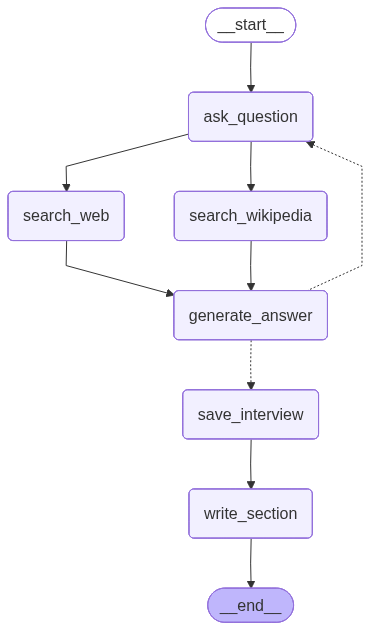

In [ ]:
display(Image(interview_graph.get_graph().draw_mermaid_png()))


### Third Workflow 


In [ ]:
from typing_extensions import TypedDict
from typing import List, Annotated
import operator
class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

In [ ]:
from langgraph.types import Send

In [ ]:
def initiate_all_interviews(state:ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """ 
    
    #check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"
    
    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                        "messages": [HumanMessage(
                                            content=f"So you said you were writing an article on {topic}?"
                                        )
                                                ]}) for analyst in state["analysts"]]

In [ ]:
# def write_report(state:ResearchGraphState):
#     """_summary_

#     Args:
#         state (ResearchGraphState): _description_
#     """
#     pass

In [26]:
report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

In [ ]:
def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

In [ ]:
intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

In [ ]:
def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

In [ ]:
def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

In [ ]:
def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

In [ ]:
# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analyst)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)



In [ ]:
memory = MemorySaver()

In [ ]:
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

In [ ]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))